In [1]:
import os
!git clone https://github.com/burf/tfdetection
os.chdir(os.path.join(os.getcwd(), "tfdetection"))
!python setup.py bdist_wheel
!pip install ./dist/tfdet-1.0.0-py3-none-any.whl
os.chdir(os.path.dirname(os.getcwd()))

Cloning into 'tfdetection'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 218 (delta 92), reused 170 (delta 59), pack-reused 0
Receiving objects: 100% (218/218), 4.18 MiB | 8.89 MiB/s, done.
Resolving deltas: 100% (92/92), done.
running bdist_wheel
running build
running build_py
creating build
creating build/lib
creating build/lib/tfdet
copying tfdet/__init__.py -> build/lib/tfdet
creating build/lib/tfdet/core
copying tfdet/core/__init__.py -> build/lib/tfdet/core
creating build/lib/tfdet/util
copying tfdet/util/metric.py -> build/lib/tfdet/util
copying tfdet/util/__init__.py -> build/lib/tfdet/util
copying tfdet/util/visualize.py -> build/lib/tfdet/util
creating build/lib/tfdet/model
copying tfdet/model/__init__.py -> build/lib/tfdet/model
creating build/lib/tfdet/core/target
copying tfdet/core/target/point_target.py -> build/lib/tfdet/core/target
copying tfdet/core/target/rcnn

In [2]:
import tensorflow as tf
import numpy as np

def pipe(data, batch_size = 128, shuffle = False):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    if shuffle:
        dataset = dataset.shuffle(buffer_size = batch_size * 10)
    dataset = dataset.batch(batch_size)
    #dataset = dataset.prefetch((batch_size * 2) + 1)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

(tr_x, tr_y), (te_x, te_y) = tf.keras.datasets.mnist.load_data()

tr_x = tr_x[(tr_y == 0)][:1000]
tr_y = tr_y[(tr_y == 0)][:1000]

te_x = te_x[np.logical_or(te_y == 0, te_y == 2)][:100]
te_y = te_y[np.logical_or(te_y == 0, te_y == 2)][:100]

tr_x = tf.image.resize(tf.tile(tf.expand_dims(tr_x, axis = -1), [1, 1, 1, 3]), [32,32]) #b, 28, 28 > b, 32, 32, 3
te_x = tf.image.resize(tf.tile(tf.expand_dims(te_x, axis = -1), [1, 1, 1, 3]), [32,32]) #b, 28, 28 > b, 32, 32, 3

tr_x = tr_x * 1/255
te_x = te_x * 1/255

batch_size = 128

tr_data = pipe(tr_x, batch_size = batch_size, shuffle = True)
te_data = pipe(te_x, batch_size = batch_size, shuffle = False)

11501568/11490434 [==============================] - 1s 0us/step


In [3]:
import tfdet

x = tf.keras.layers.Input(shape = (32, 32, 3))
feature = tfdet.model.backbone.wide_resnet50_2_torch(x)[:3]
model = tf.keras.Model(x, feature)
feature = model.predict(tr_data)

n_feature = sum([np.shape(f)[-1] for f in feature])
sampling_index = np.random.choice(np.arange(n_feature), 550, replace = False)
feature_vector = tfdet.model.train.spade.train(feature, sampling_index = sampling_index)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

In [4]:
import pickle

#save feature & sampling index
with open("feature_vector.pickle", mode = "wb") as file:
    pickle.dump(feature_vector, file)
    
with open("sampling_index.pickle", mode = "wb") as file:
    pickle.dump(sampling_index, file)

In [5]:
#load feature & sampling index
with open("feature_vector.pickle", mode = "rb") as file:
    feature_vector = pickle.load(file)

with open("sampling_index.pickle", mode = "rb") as file:
    sampling_index = pickle.load(file)

In [6]:
x = tf.keras.layers.Input(shape = (32, 32, 3))
feature = tfdet.model.backbone.wide_resnet50_2_torch(x)[:3]

score, mask = tfdet.model.detector.spade(feature, feature_vector, sampling_index = sampling_index)
model = tf.keras.Model(x, score)
y_pred = model.predict(te_data)

In [7]:
threshold = tfdet.util.metric.get_threshold((0 < te_y).astype(int), y_pred)
score, mask = tfdet.model.postprocess.spade.FilterDetection(threshold = threshold)([score, mask])
model = tf.keras.Model(x, [score, mask])

score, mask = model.predict(te_data)

y_true : True, y_pred : True


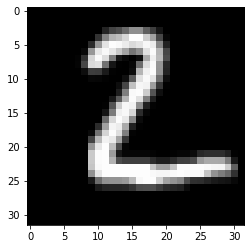

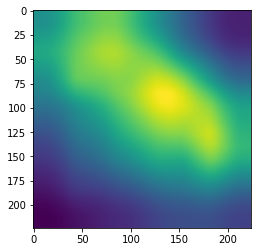

In [8]:
import matplotlib.pyplot as plt
index = 0
print("y_true : {0}, y_pred : {0}".format(0 < te_y[index], 0 < score[index]))
plt.imshow(te_x[index])
plt.figure()
plt.imshow(mask[index][..., 0])